# A simple 2D Discrete Flow Matching model

This notebook trains and evaluates a simple 2D discrete FM model with $\kappa_t = t^2$ scheduler.

Dataset: 2D discrete checkerboard
Model (probability denoiser): MLP

## Imports and init device

In [17]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.solver import MixtureDiscreteEulerSolver
from flow_matching.utils import ModelWrapper
from flow_matching.loss import MixturePathGeneralizedKL

# visualization
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [18]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [19]:
torch.manual_seed(42)

## Dataset

In [20]:
def inf_train_gen(n_grid_points: int = 128, batch_size: int = 200, device: str = "cpu") -> Tensor:
    assert n_grid_points % 4 == 0, "number of grid points has to be divisible by 4"

    n_grid_points = n_grid_points // 4

    x1 = torch.randint(low=0, high=n_grid_points * 4, size=(batch_size,), device=device)
    samples_x2 = torch.randint(low=0, high=n_grid_points, size=(batch_size,), device=device)

    x2 = (
        samples_x2
        + 2 * n_grid_points
        - torch.randint(low=0, high=2, size=(batch_size,), device=device) * 2 * n_grid_points
        + (torch.floor(x1 / n_grid_points) % 2) * n_grid_points
    )

    x_end = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1)

    return x_end.long()

## Model

In [21]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(
        self, input_dim: int = 128, time_dim: int = 1, hidden_dim=128, length=2):
        super().__init__()
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.time_embedding = nn.Linear(1, time_dim)
        self.token_embedding = torch.nn.Embedding(self.input_dim, hidden_dim)

        self.main = nn.Sequential(
            Swish(),
            nn.Linear(hidden_dim * length + time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, self.input_dim * length),
        )

    def forward(self, x, t):
        t = self.time_embedding(t.unsqueeze(-1))
        x = self.token_embedding(x)

        B, N, d = x.shape
        x = x.reshape(B, N * d)

        h = torch.cat([x, t], dim=1)
        h = self.main(h)

        h = h.reshape(B, N, self.input_dim)

        return h

## Train Discrete Flow Matching model with a uniform source distribution

In [22]:
source_distribution = "uniform"

# training arguments
lr = 0.001
batch_size = 4096
iterations = 30001
print_every = 3000

vocab_size = 128
hidden_dim = 128

epsilon = 1e-3

if source_distribution == "uniform":
    added_token = 0
elif source_distribution == "mask":
    mask_token = vocab_size  # tokens starting from zero
    added_token = 1
else:
    raise NotImplementedError

# additional mask token
vocab_size += added_token

# probability denoiser model init
probability_denoiser = MLP(input_dim=vocab_size, time_dim=1, hidden_dim=hidden_dim).to(device)

# instantiate a convex path object
scheduler = PolynomialConvexScheduler(n=2.0)
path = MixtureDiscreteProbPath(scheduler=scheduler)

# init optimizer
optim = torch.optim.Adam(probability_denoiser.parameters(), lr=lr)

loss_fn = MixturePathGeneralizedKL(path=path)

# train
start_time = time.time()

steps = 0
losses = []
for i in range(iterations):
    optim.zero_grad()

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1)
    x_1 = inf_train_gen(n_grid_points=vocab_size - added_token, batch_size=batch_size, device=device) # sample data

    if source_distribution == "uniform":
        x_0 = torch.randint_like(x_1, high=vocab_size)
    elif source_distribution == "mask":
        x_0 = torch.zeros_like(x_1) + mask_token
    else:
        raise NotImplementedError

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device) * (1 - epsilon)

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # discrete flow matching generalized KL loss
    logits = probability_denoiser(x=path_sample.x_t, t=path_sample.t)
    loss = loss_fn(logits=logits, x_1=x_1, x_t=path_sample.x_t, t=path_sample.t)

    # optimizer step
    loss.backward() # backward
    optim.step() # update

    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item()))
        start_time = time.time()

| iter   3000 |  6.10 ms/step | loss    5.697 
| iter   6000 |  4.01 ms/step | loss    5.539 
| iter   9000 |  3.97 ms/step | loss    5.296 
| iter  12000 |  3.96 ms/step | loss    5.520 
| iter  15000 |  4.02 ms/step | loss    5.714 
| iter  18000 |  3.93 ms/step | loss    5.556 
| iter  21000 |  3.98 ms/step | loss    5.392 
| iter  24000 |  4.02 ms/step | loss    5.354 
| iter  27000 |  4.21 ms/step | loss    6.423 
| iter  30000 |  3.98 ms/step | loss    5.445 


#### Sample from trained model

In [23]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return torch.softmax(self.model(x, t), dim=-1)

wrapped_probability_denoiser = WrappedModel(probability_denoiser)
solver = MixtureDiscreteEulerSolver(model=wrapped_probability_denoiser, path=path, vocabulary_size=vocab_size)

In [24]:
nfe = 64
step_size = 1 / nfe

safe_sampling = True
n_samples = 1000000
dim = 2

if source_distribution == "uniform":
    x_init = torch.randint(size=(n_samples, dim), high=vocab_size, device=device)
elif source_distribution == "mask":
    x_init = (torch.zeros(size=(n_samples, dim), device=device) + mask_token).long()
else:
    raise NotImplementedError

n_plots = 9
linspace_to_plot = torch.linspace(0,  1 - epsilon, n_plots)

sol = solver.sample(x_init=x_init,
                    step_size=step_size,
                    verbose=True,
                    return_intermediates=True,
                    time_grid=linspace_to_plot)

NFE: 64: 100%|██████████| 0.9990000128746033/0.9990000128746033 [00:16<00:00, 16.90s/it]


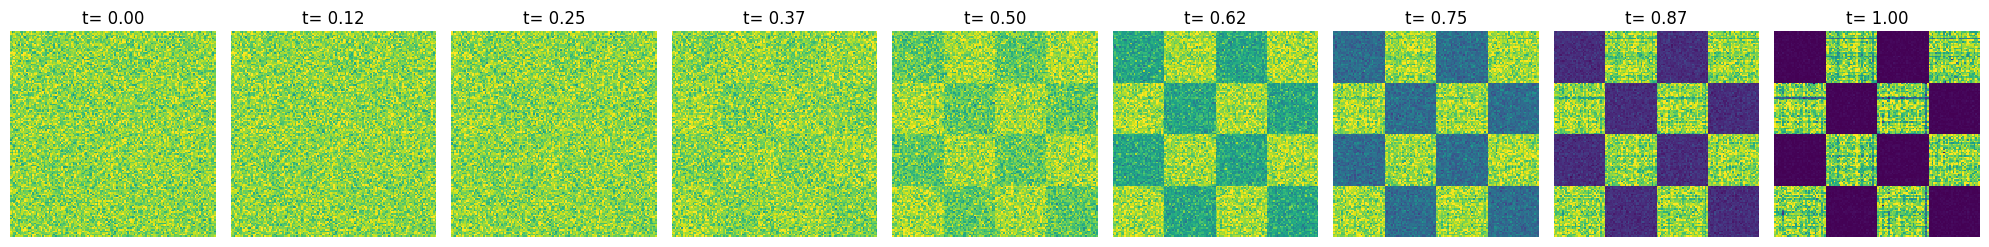

In [25]:
sol = sol.cpu().numpy()

fig, axs = plt.subplots(1, n_plots, figsize = (20, 20))

if source_distribution == "mask":
    mask_tensor = torch.tensor([mask_token, mask_token]).unsqueeze(0)

for idx, step in enumerate(linspace_to_plot):
    step = int(step.item() * nfe)

    if source_distribution == "uniform":
        sol_step = sol[idx, ...]
    elif source_distribution == "mask":
        sol_step = sol[idx, ...]
        sol_step = sol_step[torch.ne(torch.from_numpy(sol_step), mask_tensor).all(dim=1), ...]

        if sol_step.size == 0:
            axs[idx].hist2d([], [], bins=10)
            axs[idx].set_aspect('equal')
            axs[idx].axis('off')
            axs[idx].set_title('t= %.2f' % (step * step_size))

            continue
    else:
        raise NotImplementedError

    H = axs[idx].hist2d(sol_step[:, 0], sol_step[:, 1], bins=vocab_size)

    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.95).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[idx].hist2d(sol_step[:, 0], sol_step[:, 1], bins=vocab_size, norm=norm)

    axs[idx].set_aspect('equal')
    axs[idx].axis('off')
    axs[idx].set_title(f't= {linspace_to_plot[idx].item():.2f}')

plt.tight_layout()
plt.show()

## Visualize ELBO

In [26]:
n_discretization = 1024  # Time discretization of integration interval
n_samples = 10  # Number of samples to approximate the expectation on X_t ~ p_t(\cdot| x_1)

# Generalized KL function (will use it to compute the elbo)
generalized_kl_fn = MixturePathGeneralizedKL(
    path = path,
    reduction ='none'
)

# Grid of vocab_size X vocab_size
grid = torch.meshgrid(
    torch.arange(0, vocab_size, device=device),
    torch.arange(0, vocab_size, device=device),
    indexing='ij'
)
x_1 = torch.stack(
    [grid[0].reshape(-1), grid[1].reshape(-1)],
    dim=1
)

# Time discretization
discretization = (
    torch.linspace(0, 1, n_discretization + 1, device=device)[:-1]
    .view(-1, 1)
    .repeat(1, x_1.shape[0])
)

elbo = torch.zeros(size=(x_1.shape[0],), device=device)

with torch.no_grad():
    for _ in range(n_samples):
        # Lower variance estimator for time discretization
        discretization = discretization + torch.rand(
            size=(1, x_1.shape[0]), device=device
        )
        discretization = discretization % 1
        discretization = discretization * (1 - epsilon)

        for t in discretization:
            # sample X_t ~ p_t(\cdot| x_1)
            if source_distribution == "uniform":
                x_0 = torch.randint(size=x_1.shape, high=vocab_size, device=device)
            elif source_distribution == "mask":
                x_0 = (torch.zeros(size=x_1.shape, device=device) + mask_token).long()
            else:
                raise NotImplementedError

            x_t = path.sample(t=t, x_0=x_0, x_1=x_1).x_t

            logits = probability_denoiser(x_t, t)

            # compute ELBO
            elbo += -generalized_kl_fn(
                logits=logits, x_1=x_1, x_t=x_t, t=t
            ).sum(dim=1)

    elbo /= n_discretization * n_samples

# Remember that log_q(x_1) >= ELBO(x_1)
probability_lower_bound = torch.exp(elbo)

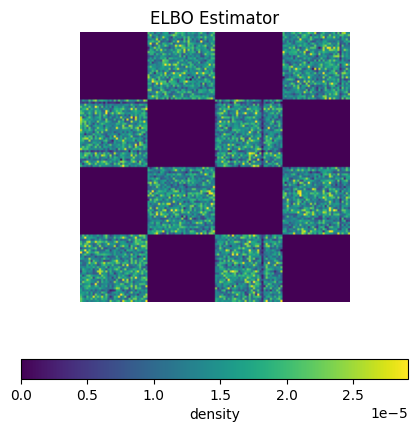

In [27]:
cmin = 0.0
cmax = probability_lower_bound.max().item() / 1.5

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

plt.figure(figsize=(5, 5))
plt.imshow(
    probability_lower_bound.reshape(vocab_size, vocab_size).cpu(),
    origin='lower', cmap='viridis', norm=norm
)
plt.gca().axis("off")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=plt.gca(), orientation='horizontal', label='density')
plt.title("ELBO Estimator")
plt.show()